In [1]:
#!pip install -q optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb
import optuna

In [3]:
df = pd.read_csv(r"/kaggle/input/restaurant-revenue-prediction/train.csv.zip")
test_df = pd.read_csv(r"/kaggle/input/restaurant-revenue-prediction/test.csv.zip")
sub = pd.read_csv(r"/kaggle/input/restaurant-revenue-prediction/sampleSubmission.csv")

In [4]:
df.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [5]:
df.columns=df.columns.str.lower()
df.drop(columns=['id', 'open date'], inplace=True)
df.head(2)

,city,city group,type,p1,p2,p3,p4,p5,p6,p7,...,p29,p30,p31,p32,p33,p34,p35,p36,p37,revenue
0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,...,3.0,0,0,0,0,0,0,0,0,6923131.0


In [6]:
df['revenue'].describe()

count    1.370000e+02
mean     4.453533e+06
std      2.576072e+06
min      1.149870e+06
25%      2.999068e+06
50%      3.939804e+06
75%      5.166635e+06
max      1.969694e+07
Name: revenue, dtype: float64

In [7]:
y = df['revenue']
X = df.drop(columns='revenue')

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.75,
                                                  random_state=42)
print(f'Train: {X_train.shape[0]} samples \t {round(X_train.shape[0] / X.shape[0] * 100)}%')
print(f'Test:  {X_test.shape[0]} samples \t {round(X_test.shape[0] / X.shape[0] * 100)}%')
print(f'Val:   {X_val.shape[0]} samples \t {round(X_val.shape[0] / X.shape[0] * 100)}%')

Train: 81 samples 	 59%
Test:  28 samples 	 20%
Val:   28 samples 	 20%


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [10]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns


num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))])


cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),])
preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11',
       'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21',
       'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['city', 'city group', 'type'], dtype='object'))])

In [11]:
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [12]:
from sklearn import metrics
def objective(trial):
  """
  Функція objective для Optuna, яка навчає модель LightGBMRegressor
  на тренувальному наборі даних та оцінює її на тестовому наборі.
  Args:
      trial (optuna.Trial): Об'єкт Optuna, що представляє один набір гіперпараметрів.
  Returns:
      float: Значення метрики оцінки (R2).
  """
  # 1. Визначення гіперпараметрів:
  params = {
        'objective': 'mse',
        'n_estimator': 30,
        'verbose': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 200, 350),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1),
    }

  model = lgb.LGBMRegressor(**params)

  model.fit(X_train, y_train)

  y_pred = model.predict(X_val)
  r2 = metrics.r2_score(y_val, y_pred)

  return r2

In [13]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [14]:
print(f"найкраща метрика: {study.best_value}")

найкраща метрика: 0.23124156849721922


In [15]:
best_params = study.best_params

model = lgb.LGBMRegressor(**best_params,
                          n_estimator = 100,
                          verbose=-1)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')

LGBMRegressor(bagging_fraction=0.8749536462309686, bagging_freq=3,
              feature_fraction=0.9935470828281345,
              lambda_l1=0.0038602393075920873, lambda_l2=2.9333578531746877e-08,
              learning_rate=0.6444435502591092, min_child_samples=7,
              n_estimator=100, num_leaves=296, verbose=-1)

In [16]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()
  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)
  return df.round(2)

In [17]:
all_metrics = pd.DataFrame()
all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))
all_metrics

,train,test
MAE,23126.19,2443110.75
RMSE,41659.54,3763562.18
R2,1.00,-0.16


In [18]:
optuna.visualization.plot_param_importances(study)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

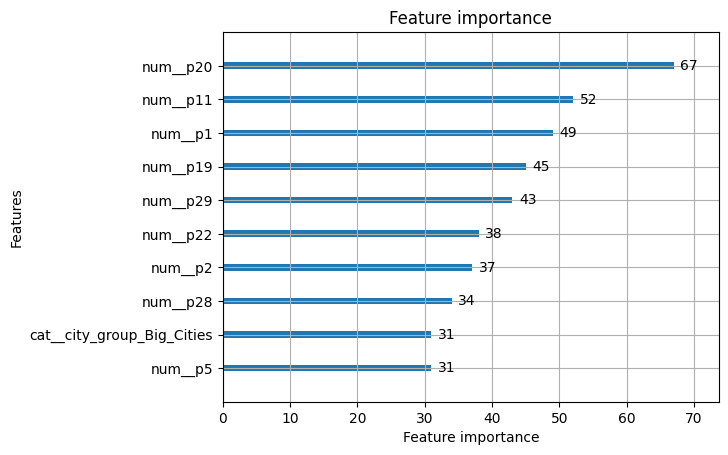

In [19]:
lgb.plot_importance(model, max_num_features=10)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

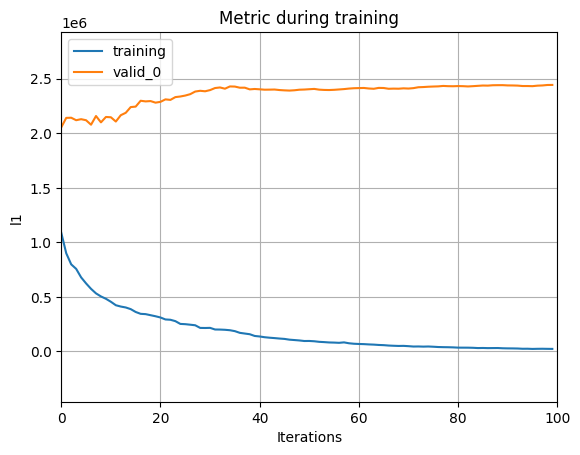

In [20]:
lgb.plot_metric(model,
                metric='l1')

In [21]:
model = Pipeline(
    [("prep", preprocessor),
     ("model", model)
     ]
)
model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11',
       'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21',
       'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37'],
      dty...
                                                                                 sparse_output=False))]),
                                                  Index(['city', 'city group', 'type'], dtype='object'))])),
                ('model',
                 LGBMRegressor(bagging_fraction=0.8749536462309686,
                               bagging_freq=3,
                               feature_fraction=0.9935470828281345,
                               lambda_l1=0.0038602393075920873,
                               lambda_l2=2.9333578531746877e-08,
                               learning_rate=0.6444435502591092,
                               min_child_samples=7, n_estimator=100,
                               num_leaves=296, verbose=-1))])